# MLP Example on 2D Data

In this notebook, we will demonstrate how to use the JLNN to build a simple Multi-layer Perceptron to classify the handcrafted dataset. First we will import all the required modules. We use `PyPlot` to plot the visualizations. We will also import necessary layers and a network essembler `SquentialNet` to build our simple architecture.

In [1]:
include("../src/NN.jl")
using NN
using PyPlot

## Data Generation

We will make a dataset with two-dimensional data with two classes. In the function `makeData`, we will make such data set according to a specififed shape. `makeData` will return a tuple of `(trX, trY)`, where `trX` is a `nx2` array that contains `n` data poitns and `trY` is an `n` dimensional vectr that cotnains the label. We use number `0` and `1` to label the two classes.

We split the data such the first 80% of the data would be for training, the rest first 10% would be for testing and 10% would be for validation.


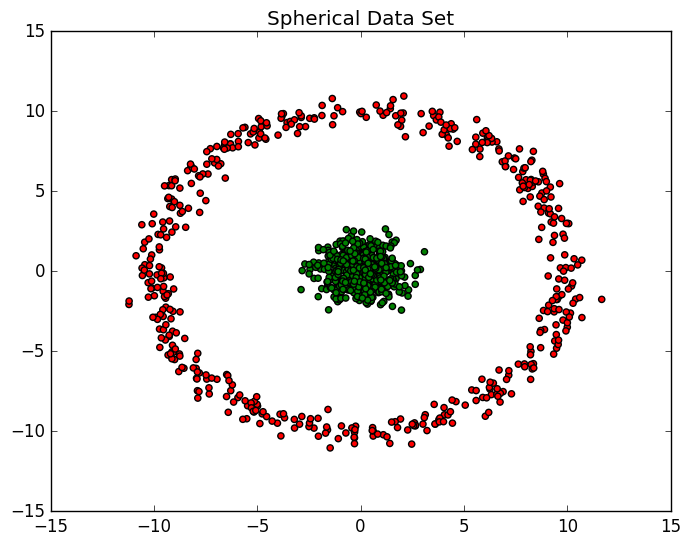

In [2]:
include("../util/datasets.jl")
X, Y = sphericalDataSet(500,500)
figure()
title("Spherical Data Set")
scatter(X[:,1], X[:,2], c=map(x-> (x >0)?"r":"g", Y))
show()

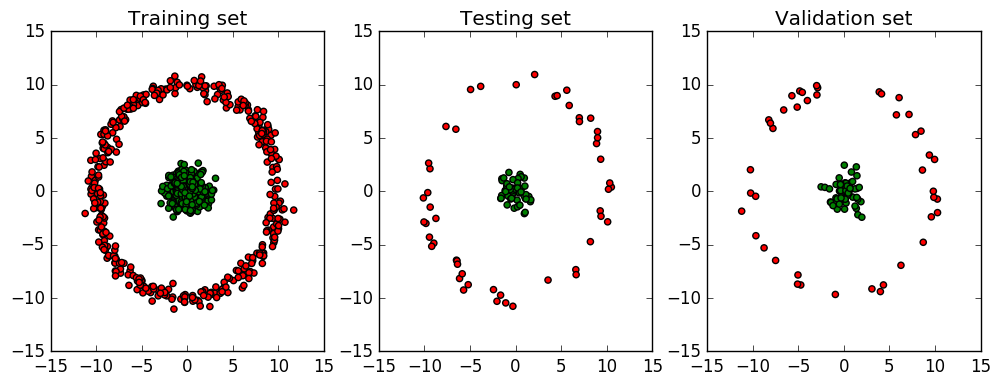

In [3]:
train_set, test_set, validation_set = datasplit(X, Y)
trX, trY = train_set[1], train_set[2]
valX, valY = validation_set[1], validation_set[2]
teX, teY = test_set[1], test_set[2]

figure(figsize=(12,4))
subplot(131)
title("Training set")
scatter(trX[:,1], trX[:,2], c=map(x-> (x >0)?"r":"g", trY[:,]))

subplot(132)
title("Testing set")
scatter(teX[:,1],teX[:,2], c=map(x-> (x >0)?"r":"g",teY[:,]))

subplot(133)
title("Validation set")
scatter(valX[:,1],valX[:,2], c=map(x-> (x >0)?"r":"g",valY[:,]))

show()


# Network Structure

Our network will have the simple architecure like the following:

![Structure Visualization using Tensorflow Playground](img/simple_net_structure.png)

We will use three fully connected layers to implement the two hidden layer. The first fully connected layer connects input to the first hidden layer. The second fully connected layer connects between two hidden layers. The third fully connect layer connects the last hidden layer to the output. 

Since we are working on a classification problem. Output of the network is piped into a `tanh` layer, so that it will become closed to either `1` or `-1` when it's large in both the positive or negative side. Then we predict the data into class `0` if the value of the output layer is less or equal to zero; `1` will be predicted if the output value is close to one.

In our example, simple square loss will be used. It has the following formua:

$$\mathcal{L} = \frac{1}{2}(y-t)^T(y-t)$$

where $y$ is the value of the output layer (`Tanh` in this case) and $t$ is the label. The derivative of this loss layer is:
$$\frac{\partial}{\partial y}\mathcal{L} = y - t$$

In [4]:
function build_net()
    layers = [
        FCLayer(2,4;init_type="Random"),
        Tanh(),
        FCLayer(4,2;init_type="Random"),
        Tanh(),
        FCLayer(2,1;init_type="Random"),
        Tanh()
    ]
    criteria = SquareLossLayer()
    net = SequentialNet(layers, criteria)
    return net
end
net = build_net()


NN.SequentialNet(NN.Layer[NN.FCLayer(2,[-0.159394 0.00479968 -0.181606 0.224106; -0.137123 -0.226854 -0.192787 0.0884483; 0.0 0.0 0.0 0.0],[0.0,0.0],[0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0],[0.0,0.0],[0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0],[0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]),NN.Tanh(Float64[],Float64[],Float64[]),NN.FCLayer(4,[-0.43545 0.381841; -0.494346 0.163219; … ; 0.317442 -0.239263; 0.0 0.0],[0.0,0.0,0.0,0.0],[0.0,0.0],[0.0,0.0],[0.0,0.0,0.0,0.0],[0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0],[0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0]),NN.Tanh(Float64[],Float64[],Float64[]),NN.FCLayer(2,[-0.448141; -0.412779; 0.0],[0.0,0.0],[0.0],[0.0],[0.0,0.0],[0.0; 0.0; 0.0],[0.0; 0.0; 0.0]),NN.Tanh(Float64[],Float64[],Float64[])],NN.SquareLossLayer(Float64[],Float64[]))

# Training / Optimization

Since we are given rather simple data, we choose normal gradient descent instead of the stochastic gradient descent. Also, for the time being we have not included momentum either, and we would add it later on.

For the learning rate, we have tried different numbers, and it turns out that a constant learning rate at 0.03 would be good enough. Also, as data set is rather simple, we have not included the learning rate dropping.

In [5]:
function get_corr(pred, answ)
    return length(filter(e -> abs(e) < 1e-5, pred-answ))
end

function train(net::SequentialNet, train_set, validation_set; 
        batch_size::Int64 = 64, ttl_epo::Int64 = 10, lrSchedule = (x -> 0.01), verbose = 0,)
    trX, trY = train_set
    valX, valY = validation_set
    local N = size(Y)[1]
    local batch=0
    local epo_losses = []
    local all_losses = []
    local all_accu   = []
    
    local val_losses = []
    local val_accu   = []
    for epo = 1:ttl_epo
        local num_batch = ceil(N/batch_size)
        if verbose > 0
            println("Epo $(epo) num batches : $(num_batch)")
        end
        epo_cor = 0
        for bid = 0:num_batch
            batch += 1
            local sidx::Int = convert(Int64, bid*batch_size+1)
            local eidx::Int = convert(Int64, min(N, (bid+1)*batch_size))
            local batch_X = X[sidx:eidx,:]
            local batch_Y = Y[sidx:eidx,:]
            loss, pred = forward(net, batch_X, batch_Y)
            loss = mean(loss)
            epo_cor  += get_corr(pred, batch_Y)
            local acc = get_corr(pred, batch_Y) / batch_size
            backward(net, batch_Y)
            for i = 1:length(net.layers)
                local layer = net.layers[i]
                local gradi = lrSchedule(epo) * NN.gradient(layer) / batch_size
                local theta = getParam(layer) - gradi
                if verbose > 1
                    print("Layer $(i)")
                    print("\tGradient: $(sum(abs(theta - getLDiff(layer))))")
                    if verbose > 1
                        print("\tLastloss: $(sum(abs(layer.last_loss)))")
                    end
                    println()
                end
                setParam!(layer, theta)
            end
            append!(all_losses, loss)
            if verbose > 1
                println("[$(bid)/$(num_batch)]Loss is: $(loss)\tAccuracy:$(acc)")
            end
        end
        local epo_loss = mean(all_losses)
        local epo_accu = epo_cor / N
        append!(all_accu, epo_accu)
        append!(epo_losses, epo_loss)
        
        # Run validation set
        v_loss, v_pred = forward(net, valX, valY)
        v_size = size(valX)[1]
        v_accu = get_corr(v_pred, valY) / v_size
        append!(val_losses, v_loss)
        append!(val_accu,   v_accu)
        
        if verbose > 0
            println("Epo $(epo):")
            println("Train:\t$(epo_loss)\taccuracy : $(epo_accu)")
            println("Validation:\t$(v_loss)\taccuracy : $(v_accu)")
        end
    end
    return epo_losses, all_losses, all_accu, val_losses, val_accu
end

train (generic function with 1 method)

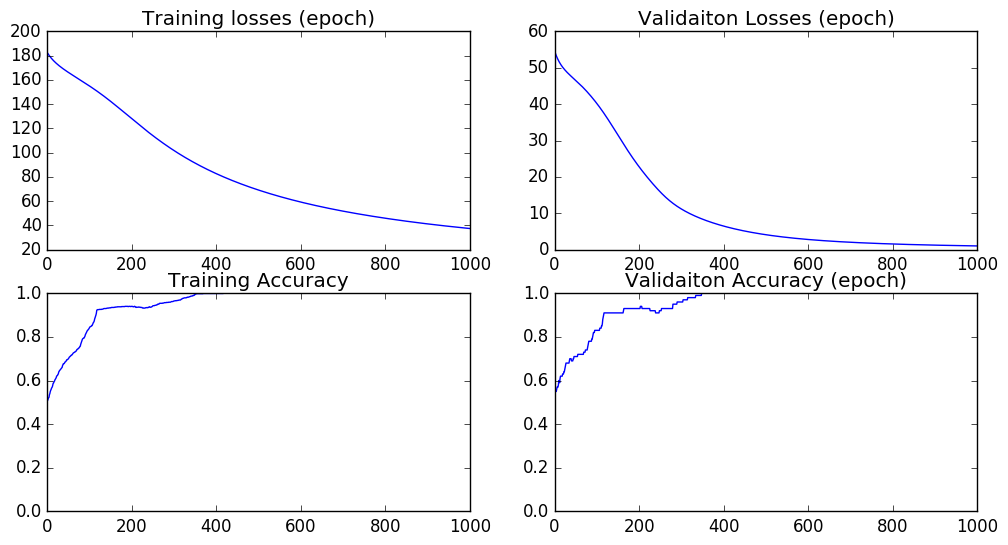

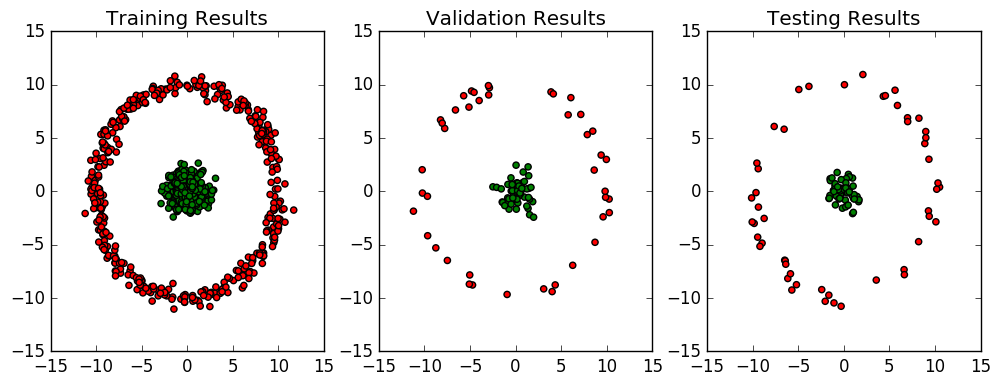

PyObject <matplotlib.text.Text object at 0x32857e0d0>

In [6]:
function demoTrain(trX, trY, valX, valY, teX, teY;ttl_epo=5000)
    net = build_net()
    all_losses, batch_losses, all_accu, v_loss, v_accu = train(net, (trX, trY), (valX, valY); 
            ttl_epo = ttl_epo, batch_size = size(trX)[1],
            lrSchedule = x -> 0.03, verbose = 0)

    figure(figsize=(12,6))
    subplot(221)
    plot(1:length(all_losses), all_losses)
    title("Training losses (epoch)")

    subplot(223)
    plot(1:length(all_accu), all_accu)
    ylim([0, 1])
    title("Training Accuracy")

    subplot(222)
    plot(1:length(v_loss), v_loss)
    title("Validaiton Losses (epoch)")

    subplot(224)
    plot(1:length(v_accu), v_accu)
    ylim([0, 1])
    title("Validaiton Accuracy (epoch)")

    figure(figsize=(12,4))
    subplot(131)
    _, pred = forward(net, trX, trY)
    scatter(trX[:,1], trX[:,2], c=map(x-> (x >0)? "r" : "g", pred[:,1]))
    title("Training Results")

    subplot(132)
    _, pred = forward(net, valX, valY)
    scatter(valX[:,1], valX[:,2], c=map(x-> (x >0)? "r" : "g", pred[:,1]))
    title("Validation Results")

    subplot(133)
    _, pred = forward(net, teX, teY)
    scatter(teX[:,1], teX[:,2], c=map(x-> (x >0)? "r" : "g", pred[:,1]))
    title("Testing Results")
end
demoTrain(trX, trY, valX, valY, teX, teY;ttl_epo=1000)

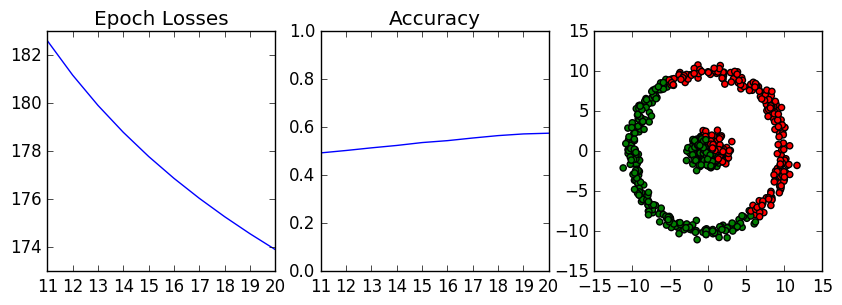

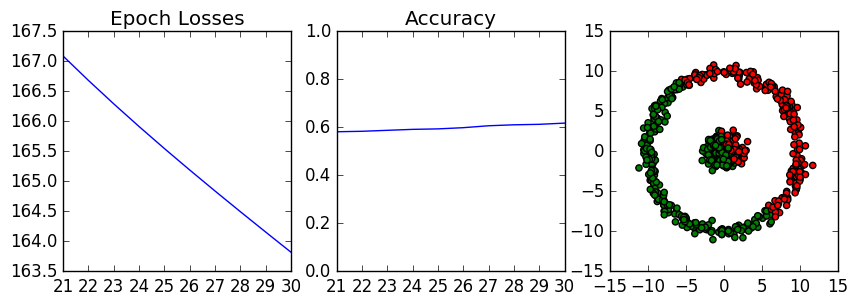

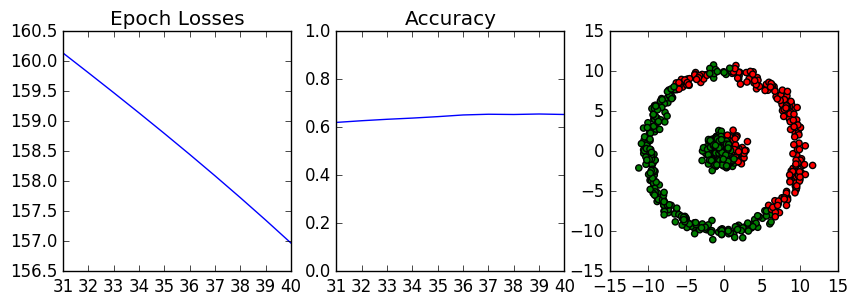

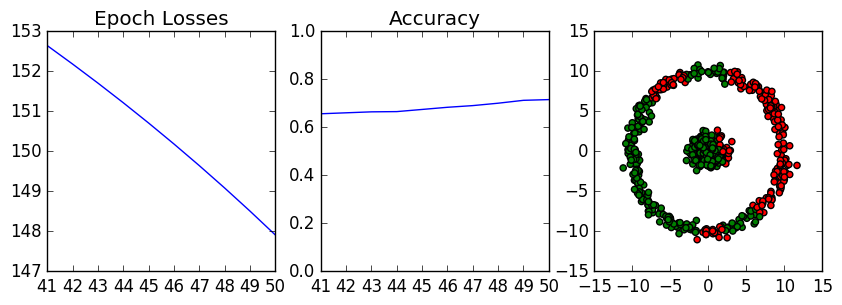

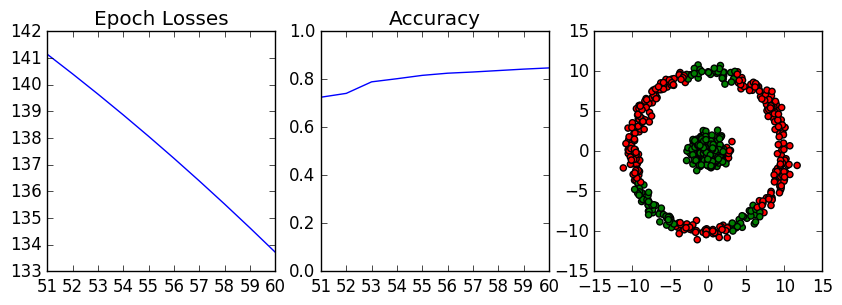

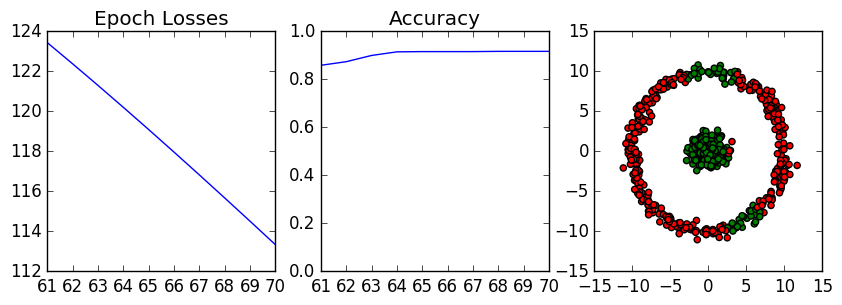

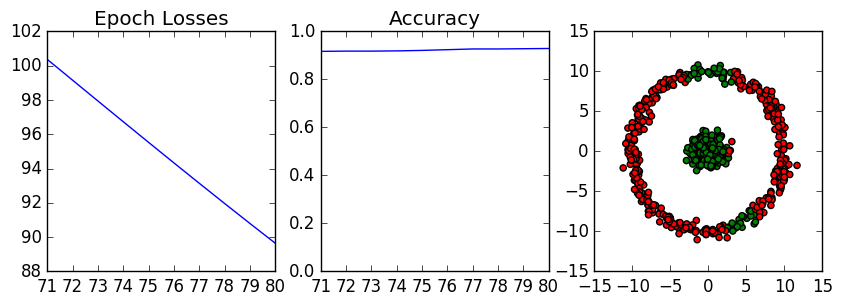

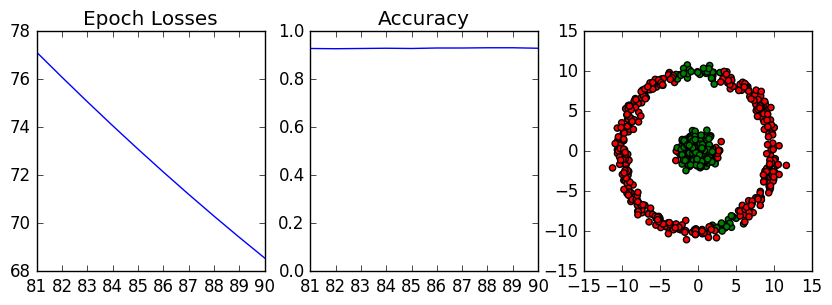

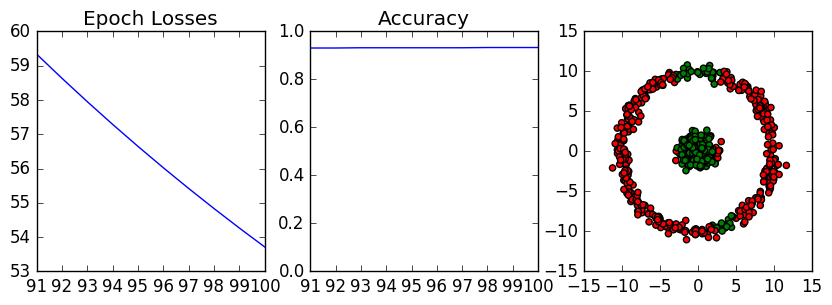

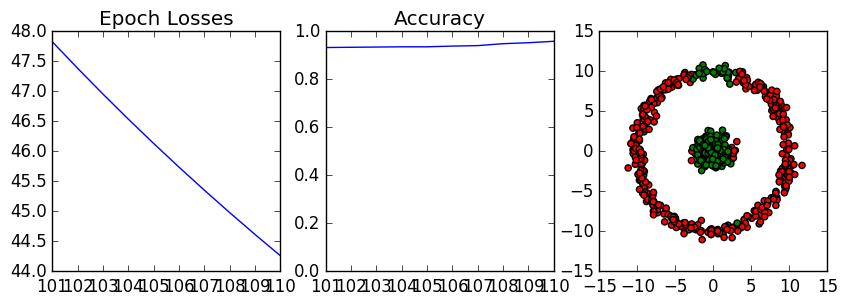

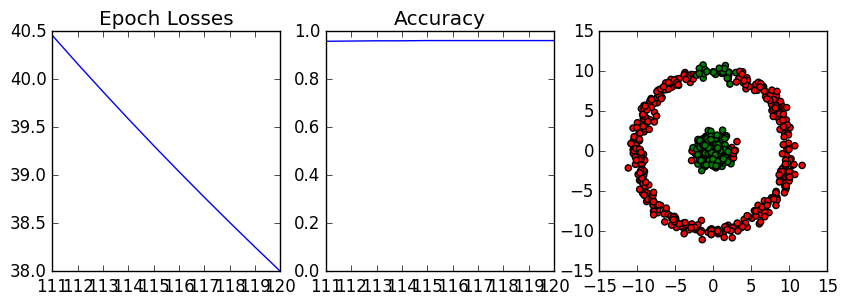

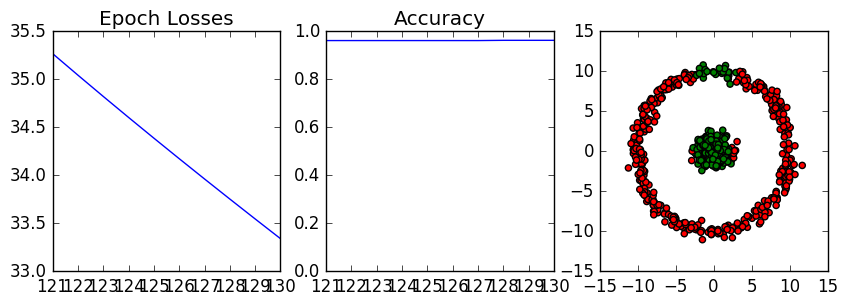

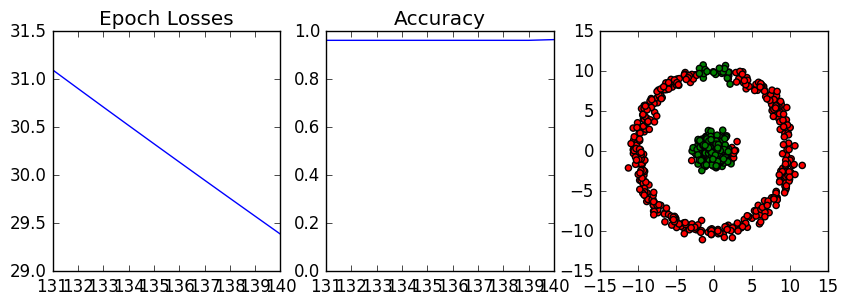

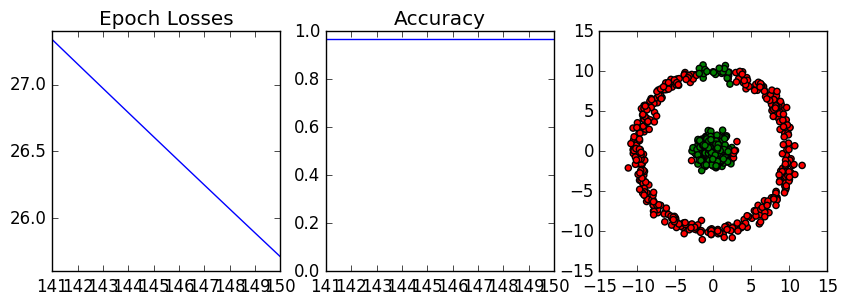

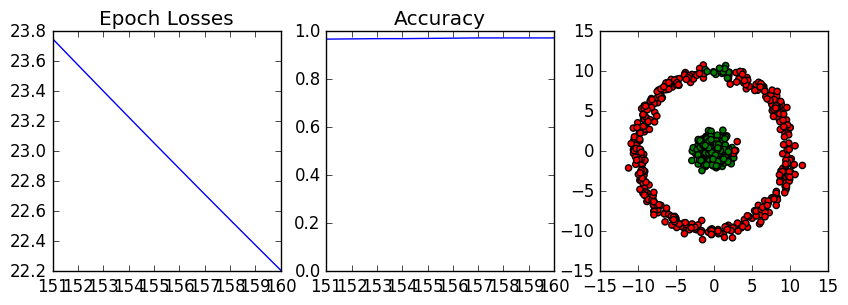

  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/Grendel/.julia/v0.5/PyCall/src/PyCall.jl
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/Grendel/.juli

In [7]:
function demoTrainWithBreaks(trX, trY, valX, valY, teX, teY; epo_run = 1000, times=10)
    net = build_net()
    all_losses = []
    all_accu = []
    for i = 1:times
        epo_losses, batch_losses, epo_accu = train(net, (trX, trY),(valX, valY);
        ttl_epo = epo_run, batch_size = size(trX)[1], lrSchedule = x->(x<2000)?0.1:0.01, verbose = 0)
        all_losses = vcat(all_losses, epo_losses)
        all_accu   = vcat(all_accu, epo_accu)
        figure(figsize=(10,3))
        subplot(131)
        plot((1+i*epo_run):(length(epo_losses)+i*epo_run), epo_losses)
        title("Epoch Losses")
        subplot(132)
        plot((1+i*epo_run):(length(epo_accu)+i*epo_run), epo_accu)
        ylim([0, 1])
        title("Accuracy")
        _, pred = forward(net, trX, trY)
        subplot(133)
        scatter(trX[:,1], trX[:,2], c=map(x-> (x >0)? "r" : "g", pred[:,1]))
    end
end
demoTrainWithBreaks(trX, trY, valX, valY, teX, teY;epo_run=10,times=15)

## XOR Data Set

Now we will construct the XOR dataset, which Perceptrons failed to classify yet the simple nerual network described above will be able to.

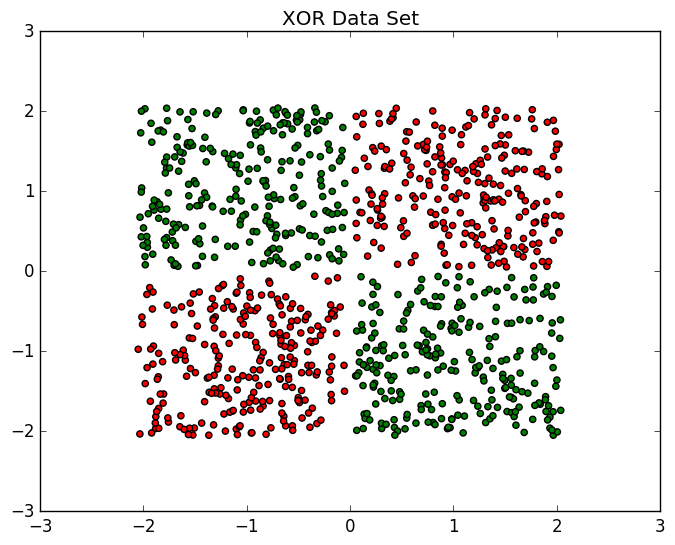

PyObject <matplotlib.collections.PathCollection object at 0x115299910>

In [8]:
X, Y = XORData(250;dist=0.05,scale = 2)
title("XOR Data Set")
scatter(X[:,1], X[:,2], c=map(x-> (x >0)?"r":"g",Y[:,1]))



Now we will split the XOR data set into training, validation, and testing portions.

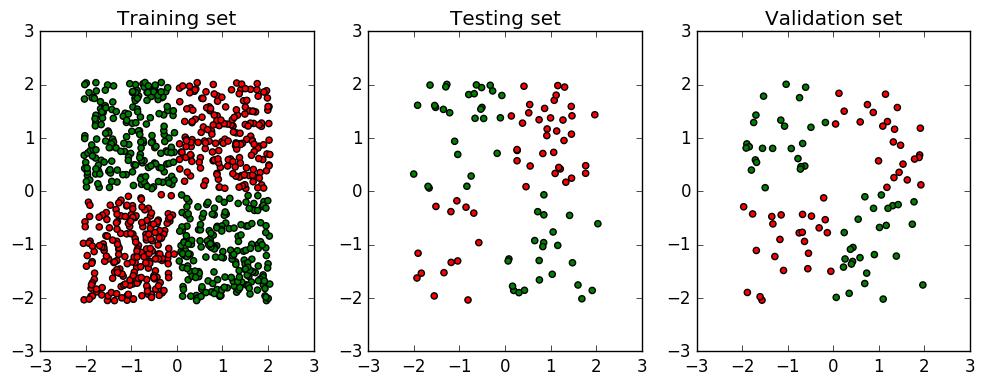

PyObject <matplotlib.collections.PathCollection object at 0x32b334850>

In [9]:
(trX, trY),(teX, teY),(valX, valY) = datasplit(X,Y)
figure(figsize=(12,4))
subplot(131)
title("Training set")
scatter(trX[:,1], trX[:,2], c=map(x-> (x >0)?"r":"g", trY[:,]))

subplot(132)
title("Testing set")
scatter(teX[:,1],teX[:,2], c=map(x-> (x >0)?"r":"g",teY[:,]))

subplot(133)
title("Validation set")
scatter(valX[:,1],valX[:,2], c=map(x-> (x >0)?"r":"g",valY[:,]))


Finally, we will use the same network structure to train on the XOR data set.

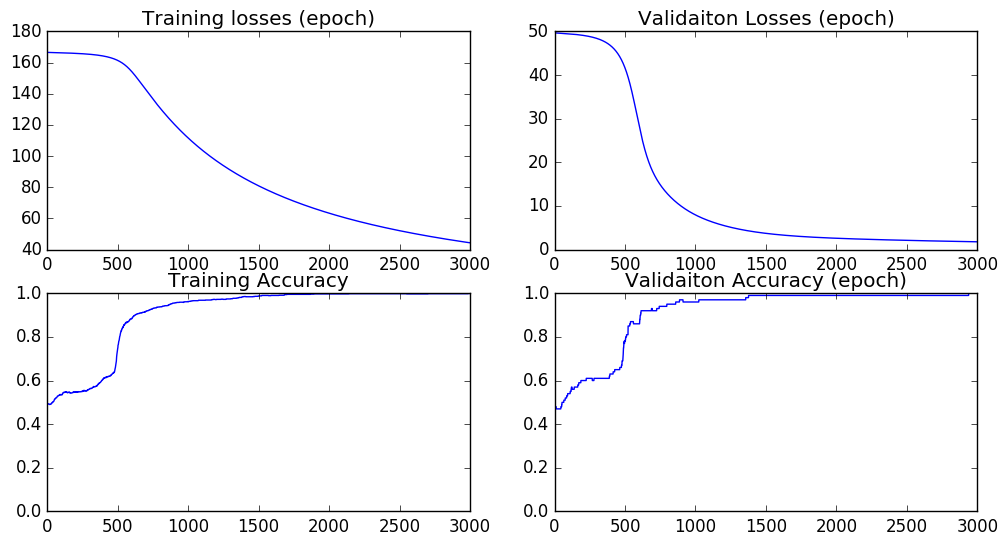

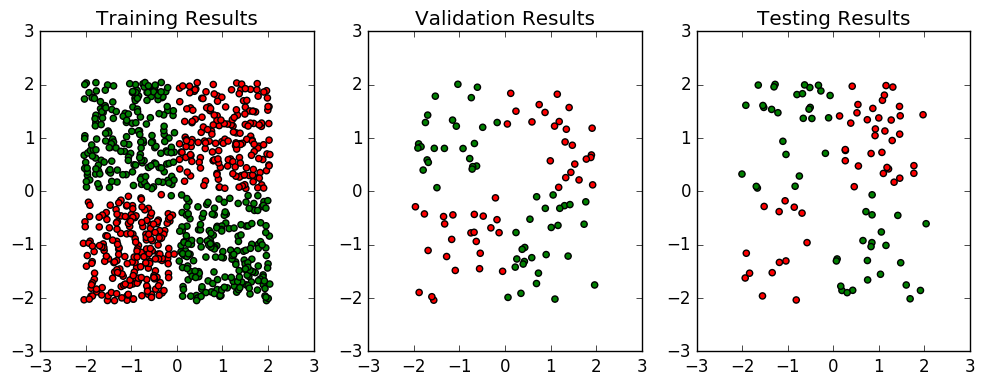

PyObject <matplotlib.text.Text object at 0x32a59f110>

In [10]:
demoTrain(trX, trY, valX, valY, teX, teY;ttl_epo=3000)

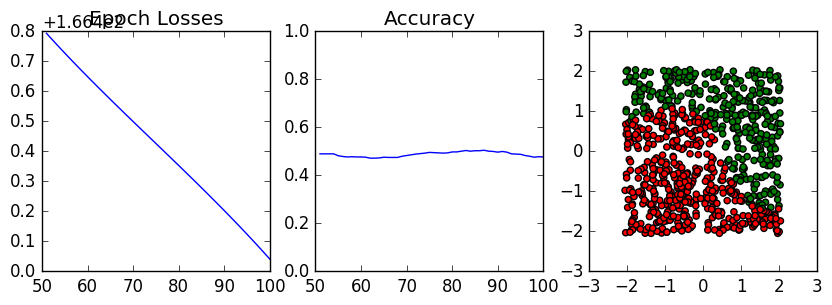

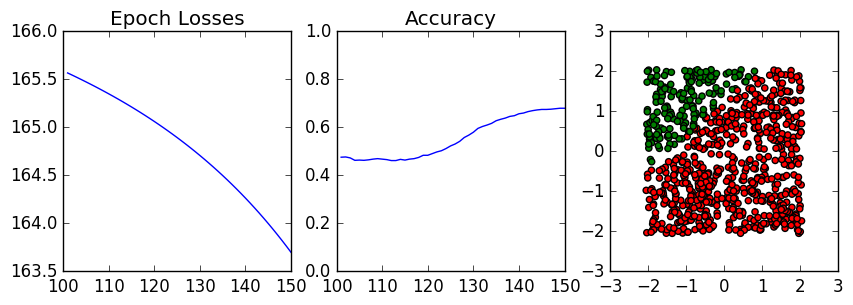

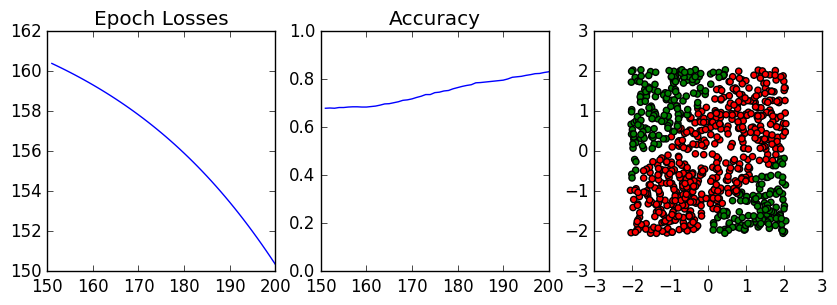

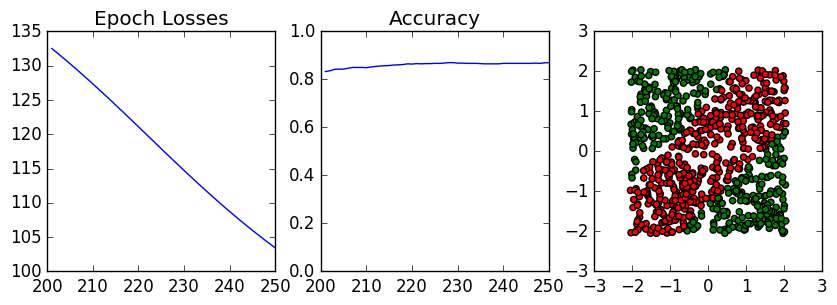

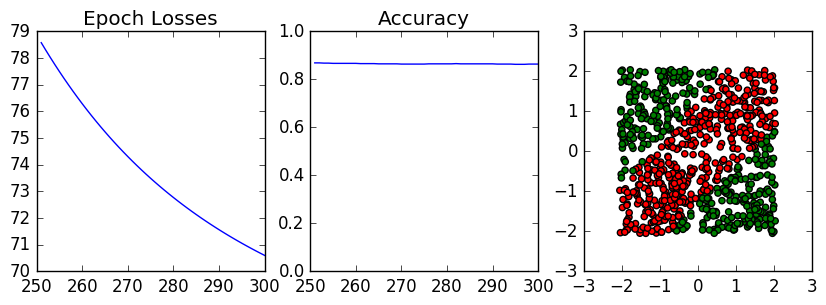

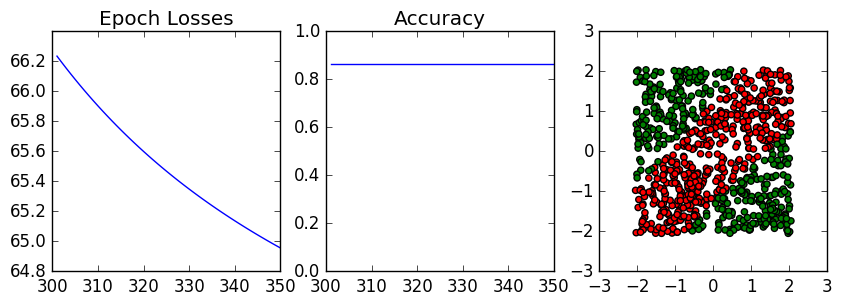

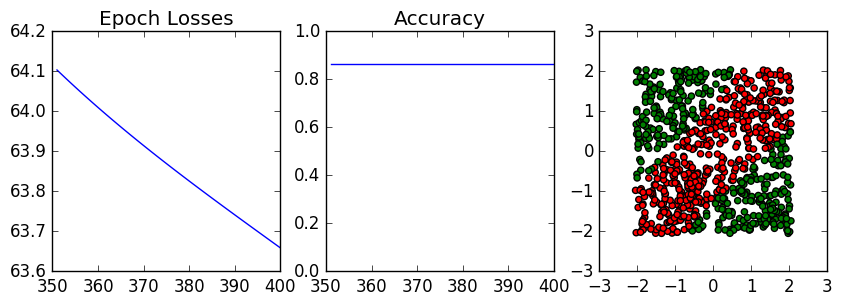

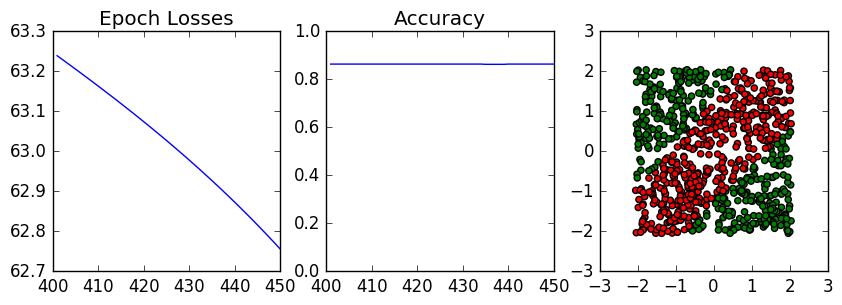

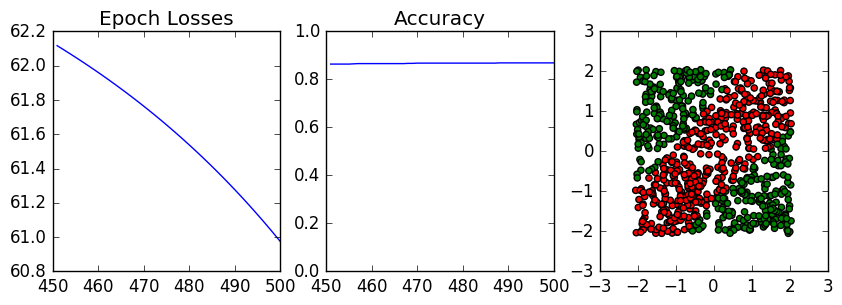

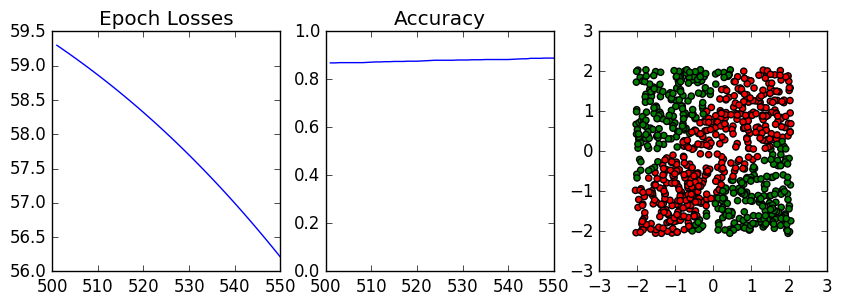

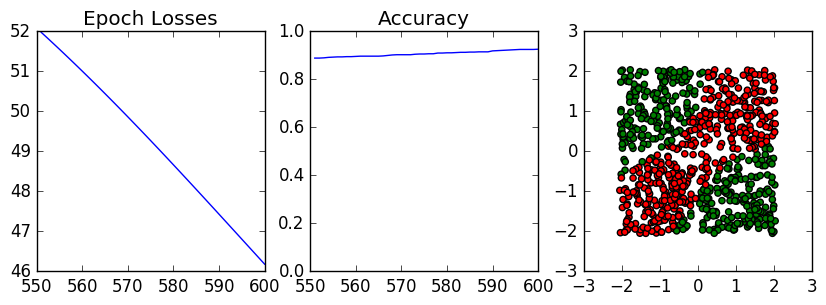

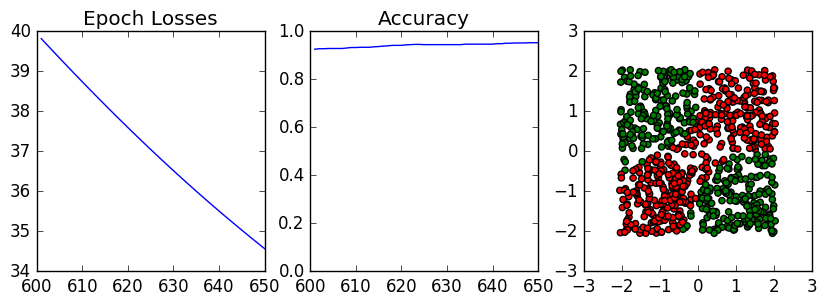

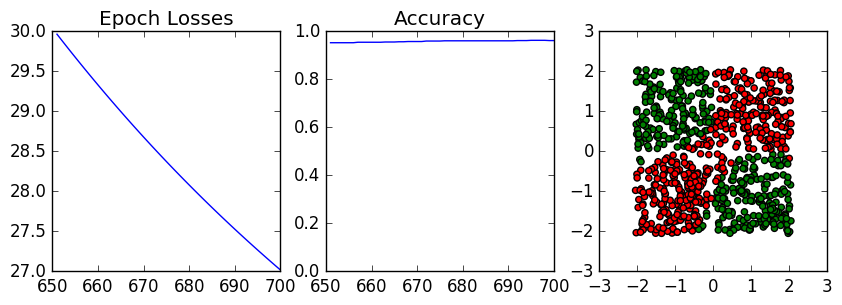

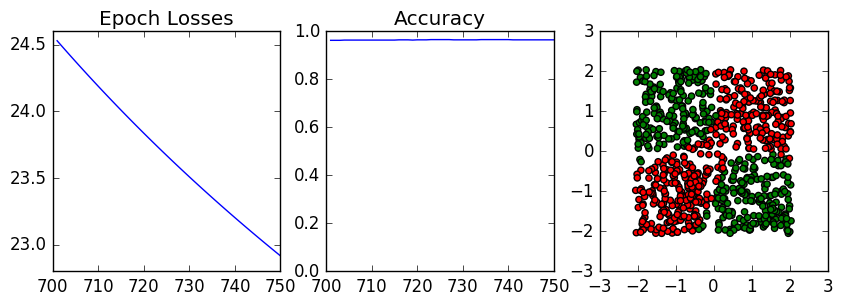

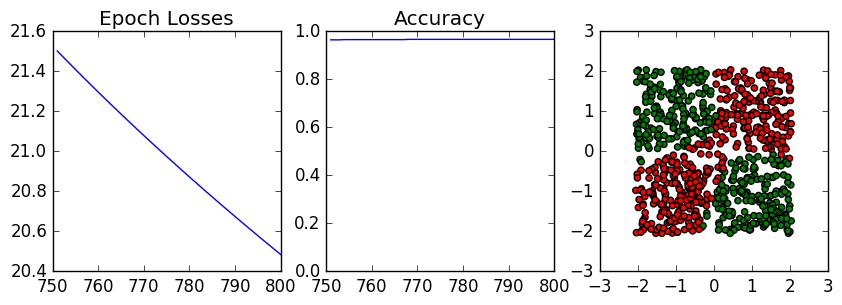

In [11]:
demoTrainWithBreaks(trX, trY, valX, valY, teX, teY;epo_run=50,times=15)